In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
path = "global_disaster_response_2018_2024.csv"
df = pd.read_csv(path)

In [6]:
FEATURES = [
    "country",
    "disaster_type",
    "severity_index",
    "casualties",
    "response_time_hours",
    "aid_amount_usd",
    "response_efficiency_score",
    "recovery_days",
]
TARGET = "economic_loss_usd"

X = df[FEATURES].copy()
y = df[TARGET].copy()

# (tùy chọn) bỏ dòng thiếu target
mask = y.notna()
X, y = X[mask], y[mask]

In [7]:
cat_cols = ["country", "disaster_type"]

num_cols = [
    "severity_index",
    "casualties",
    "response_time_hours",
    "aid_amount_usd",
    "response_efficiency_score",
    "recovery_days",
]

log_cols = ["casualties", "response_time_hours", "aid_amount_usd"]
nonlog_cols = [c for c in num_cols if c not in log_cols]
log1p_transformer = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

numeric_log_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log1p", log1p_transformer),
])

numeric_nonlog_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", categorical_pipe, cat_cols),
        ("num_log", numeric_log_pipe, log_cols),
        ("num", numeric_nonlog_pipe, nonlog_cols),
    ],
    remainder="drop",
)

In [8]:
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=None
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model),
])

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipe.fit(X_train, y_train)         

pred = pipe.predict(X_test)       

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)



MAE : 2004481.54853327
RMSE: 2659317.0670991875
R2  : 0.33439243813177044


In [11]:
custom_sample = pd.DataFrame([{
    "country": "Brazil",
    "disaster_type": "Earthquake",
    "severity_index": 5.99,
    "casualties": 111,
    "response_time_hours": 15.62,
    "aid_amount_usd": 271603.79,
    "response_efficiency_score": 83.21,
    "recovery_days": 67
}])
# kết quả đúng 7,934,365.71 USD

predicted_loss = pipe.predict(custom_sample)

print(f"Dự đoán economic_loss_usd: {predicted_loss[0]:,.2f} USD")

Dự đoán economic_loss_usd: 7,242,088.85 USD


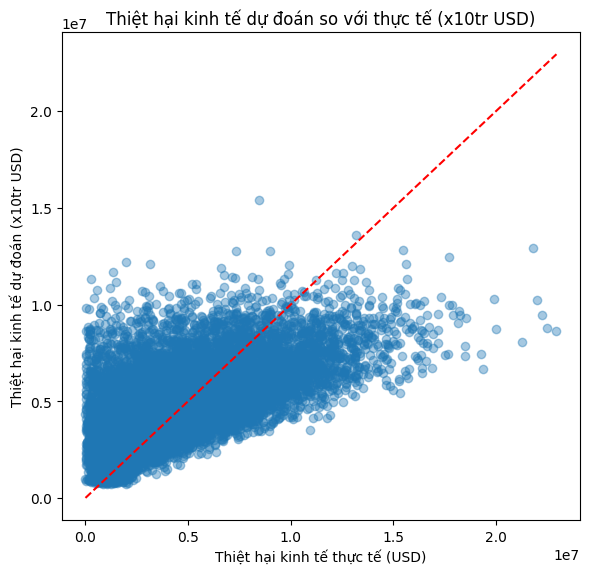

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, alpha=0.4)


plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red",
    linestyle="--"
)

plt.xlabel("Thiệt hại kinh tế thực tế (USD)")
plt.ylabel("Thiệt hại kinh tế dự đoán (x10tr USD)")
plt.title("Thiệt hại kinh tế dự đoán so với thực tế (x10tr USD)")
plt.tight_layout()
plt.show()



RandomForestRegression mô hình dự đoán những thiệt hại kinh tế thấp sẽ chuẩn xác hợn các thiệt hại cao
- các thiệt hại thực tế thường cao hơn so với dự đoán, cả 3 mô hình cho kết quả khá tương đương nhau